# **Image Classification Model Training**

### Imports

In [1]:
import os
import json
import random
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences # type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
# from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore

2024-08-28 20:51:06.986984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 20:51:07.000801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 20:51:07.004759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 20:51:07.014635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 20:51:07.853590: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", (tf.config.list_physical_devices()))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724858468.566271   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724858468.592377   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724858468.595298   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
training_folder = '../data/images/training/'
validation_folder = '../data/images/validation/'

training_sensitive_dir = os.path.join(training_folder + 'sensitive/')
training_nonsensitive_dir = os.path.join(training_folder + 'nonsensitive/')
validation_sensitive_dir = os.path.join(validation_folder + 'sensitive/')
validation_nonsensitive_dir = os.path.join(validation_folder + 'nonsensitive/')

In [4]:
# Image Dataset size
print('Total training sensitive images:', len(os.listdir(training_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(training_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 300
Total training nonsensitive images: 300
Total validation sensitive images: 50
Total validation nonsensitive images: 50


## Sample Data

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

In [7]:
train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

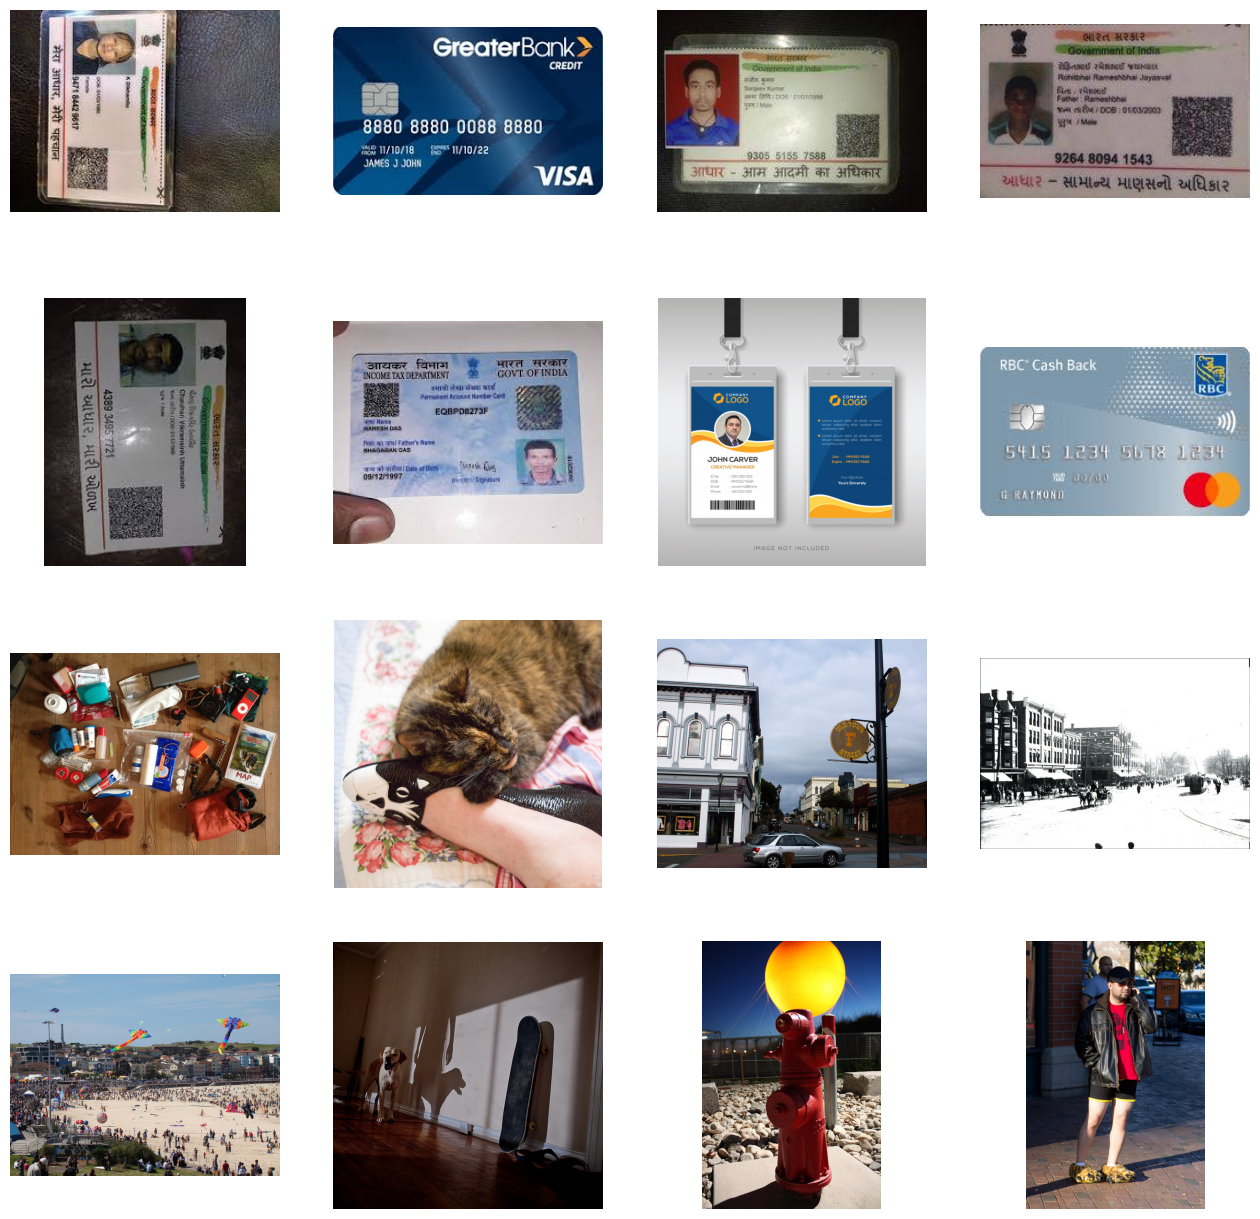

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)


plt.show()

## Model

In [9]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
from tensorflow.keras.optimizers import RMSprop #type:ignore
DESIRED_ACCURACY = 0.98


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > DESIRED_ACCURACY:
            print("Reached 98% accuracy so cancelling training!")
            self.model.stop_training = True


callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
    # 2D Convolution Layer - Filter, Kernel_size, activation fn
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(150, 150, 3)),
    # Max pooling operation for 2D data - Pool size
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flattens the input. Does not affect the batch size.
    tf.keras.layers.Flatten(),
    # Regular densely-connected Neural Network layer with ReLU activation function.
    tf.keras.layers.Dense(512, activation='relu'),
    # Regular densely-connected Neural Network layer with sigmoid activation function.
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

I0000 00:00:1724858469.608260   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724858469.611667   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724858469.614448   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724858469.729506   13026 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocessing, Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [11]:
# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

In [12]:
# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
    training_folder,
    target_size=(150, 150),
    batch_size=30,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_folder,
    target_size=(150, 150),
    batch_size=5,
    class_mode='binary',
    shuffle=True
)

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


## Model Training

In [13]:
num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=num_epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=8,
    callbacks=[callbacks])

Epoch 1/500


I0000 00:00:1724858473.035350   13142 service.cc:146] XLA service 0x7f9138001680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724858473.035380   13142 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-08-28 20:51:13.068054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 20:51:13.276976: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:04 7s/step - accuracy: 0.4667 - loss: 0.6950

I0000 00:00:1724858477.928576   13142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.5195 - loss: 0.8566 - val_accuracy: 0.7250 - val_loss: 0.6300
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6781 - loss: 0.6176 - val_accuracy: 0.8500 - val_loss: 0.4218
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.3659
Epoch 4/500


2024-08-28 20:51:20.478327: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-28 20:51:20.478359: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-28 20:51:20.509375: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:51:20.509533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:20.509552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6445 - loss: 0.6160 - val_accuracy: 0.8250 - val_loss: 0.5261
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7523 - loss: 0.5431 - val_accuracy: 0.8750 - val_loss: 0.2872
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.3292
Epoch 7/500


2024-08-28 20:51:23.640170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:23.640201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:23.676477: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:51:23.676534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:23.676560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8299 - loss: 0.4241 - val_accuracy: 0.8750 - val_loss: 0.3133
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7407 - loss: 0.5143 - val_accuracy: 0.8750 - val_loss: 0.3436
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.3557
Epoch 10/500


2024-08-28 20:51:26.739460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:26.739510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:26.776250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:26.776283: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8062 - loss: 0.4568 - val_accuracy: 0.8750 - val_loss: 0.3143
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7384 - loss: 0.5253 - val_accuracy: 0.8250 - val_loss: 0.3774
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.3680
Epoch 13/500


2024-08-28 20:51:29.946081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:29.946129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:29.977877: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:51:29.977910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:29.977922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7394 - loss: 0.5547 - val_accuracy: 0.8500 - val_loss: 0.3638
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7605 - loss: 0.4663 - val_accuracy: 0.8250 - val_loss: 0.3531
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2623
Epoch 16/500


2024-08-28 20:51:33.065460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:33.105980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:33.106009: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.8147 - loss: 0.4058 - val_accuracy: 0.9250 - val_loss: 0.2339
Epoch 17/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7622 - loss: 0.4999 - val_accuracy: 0.9250 - val_loss: 0.3394
Epoch 18/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6214
Epoch 19/500


2024-08-28 20:51:36.129367: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:36.129416: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:36.162854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:36.162899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7720 - loss: 0.5345 - val_accuracy: 0.9250 - val_loss: 0.3056
Epoch 20/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8084 - loss: 0.4526 - val_accuracy: 0.8500 - val_loss: 0.3637
Epoch 21/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.3352
Epoch 22/500


2024-08-28 20:51:39.173659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:39.173689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:39.224573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:39.224621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.7952 - loss: 0.4636 - val_accuracy: 0.9000 - val_loss: 0.2827
Epoch 23/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8661 - loss: 0.3744 - val_accuracy: 0.9750 - val_loss: 0.1718
Epoch 24/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.3206
Epoch 25/500


2024-08-28 20:51:42.210054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:42.210104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:42.248271: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:51:42.248299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:42.248310: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8217 - loss: 0.3872 - val_accuracy: 0.9500 - val_loss: 0.2717
Epoch 26/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8752 - loss: 0.3813 - val_accuracy: 0.9250 - val_loss: 0.1957
Epoch 27/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1786
Epoch 28/500


2024-08-28 20:51:45.241495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:45.241527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:45.272181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:45.272225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7586 - loss: 0.4592 - val_accuracy: 0.9500 - val_loss: 0.2954
Epoch 29/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7750 - loss: 0.4400 - val_accuracy: 0.9250 - val_loss: 0.2226
Epoch 30/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1892
Epoch 31/500


2024-08-28 20:51:48.327792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:48.327828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:48.372000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:48.372046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8195 - loss: 0.4363 - val_accuracy: 0.9000 - val_loss: 0.2640
Epoch 32/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8175 - loss: 0.3773 - val_accuracy: 0.9000 - val_loss: 0.1955
Epoch 33/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2348
Epoch 34/500


2024-08-28 20:51:51.439519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:51.439575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.7943 - loss: 0.4275 - val_accuracy: 0.9750 - val_loss: 0.1903
Epoch 35/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8464 - loss: 0.3759 - val_accuracy: 0.9750 - val_loss: 0.1592
Epoch 36/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1438
Epoch 37/500


2024-08-28 20:51:54.455020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:54.455054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:54.495940: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:54.495986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8225 - loss: 0.3776 - val_accuracy: 0.9000 - val_loss: 0.2396
Epoch 38/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7838 - loss: 0.4401 - val_accuracy: 0.8750 - val_loss: 0.2952
Epoch 39/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.3717
Epoch 40/500


2024-08-28 20:51:57.432415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:57.432467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:51:57.491530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:51:57.491558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.8503 - loss: 0.3608 - val_accuracy: 0.9500 - val_loss: 0.1026
Epoch 41/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7961 - loss: 0.3765 - val_accuracy: 1.0000 - val_loss: 0.1509
Epoch 42/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1450
Epoch 43/500


2024-08-28 20:52:00.590368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:00.643801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:00.643834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8605 - loss: 0.3447 - val_accuracy: 0.8750 - val_loss: 0.2040
Epoch 44/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8065 - loss: 0.4075 - val_accuracy: 0.9250 - val_loss: 0.2614
Epoch 45/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2750
Epoch 46/500


2024-08-28 20:52:03.847049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:03.847093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:03.892599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:03.892652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8975 - loss: 0.2702 - val_accuracy: 0.9750 - val_loss: 0.0539
Epoch 47/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8478 - loss: 0.3494 - val_accuracy: 0.9750 - val_loss: 0.1285
Epoch 48/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1337
Epoch 49/500


2024-08-28 20:52:07.138224: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:52:07.138251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:07.138262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8817 - loss: 0.2737 - val_accuracy: 1.0000 - val_loss: 0.0892
Epoch 50/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8337 - loss: 0.3870 - val_accuracy: 0.9500 - val_loss: 0.1317
Epoch 51/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1433
Epoch 52/500


2024-08-28 20:52:10.370770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:10.370835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:10.421402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:10.421454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8535 - loss: 0.3418 - val_accuracy: 0.9500 - val_loss: 0.0816
Epoch 53/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8520 - loss: 0.3488 - val_accuracy: 0.9750 - val_loss: 0.1370
Epoch 54/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1477
Epoch 55/500


2024-08-28 20:52:13.625616: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:13.625656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8803 - loss: 0.3318 - val_accuracy: 0.9500 - val_loss: 0.0830
Epoch 56/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8638 - loss: 0.2933 - val_accuracy: 0.9000 - val_loss: 0.2560
Epoch 57/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.2951
Epoch 58/500


2024-08-28 20:52:16.660889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:16.660935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:16.722110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:16.722160: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8589 - loss: 0.3500 - val_accuracy: 0.9500 - val_loss: 0.1133
Epoch 59/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8943 - loss: 0.3177 - val_accuracy: 1.0000 - val_loss: 0.0622
Epoch 60/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1245
Epoch 61/500


2024-08-28 20:52:19.583047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:19.583083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:19.615028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:19.615080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9063 - loss: 0.3115 - val_accuracy: 1.0000 - val_loss: 0.0310
Epoch 62/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8954 - loss: 0.2706 - val_accuracy: 0.9250 - val_loss: 0.1403
Epoch 63/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.1738
Epoch 64/500


2024-08-28 20:52:22.628172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:22.628211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:22.665727: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:22.665774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9112 - loss: 0.2244 - val_accuracy: 0.9250 - val_loss: 0.2089
Epoch 65/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8988 - loss: 0.2355 - val_accuracy: 0.9500 - val_loss: 0.1347
Epoch 66/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1222
Epoch 67/500


2024-08-28 20:52:25.586592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:25.586639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:25.617892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:25.617925: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8999 - loss: 0.2654 - val_accuracy: 0.9500 - val_loss: 0.1526
Epoch 68/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8525 - loss: 0.3126 - val_accuracy: 0.9750 - val_loss: 0.0977
Epoch 69/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0594
Epoch 70/500


2024-08-28 20:52:28.786531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:28.786567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8895 - loss: 0.2923 - val_accuracy: 0.9500 - val_loss: 0.1228
Epoch 71/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9075 - loss: 0.2395 - val_accuracy: 1.0000 - val_loss: 0.0344
Epoch 72/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1637
Epoch 73/500


2024-08-28 20:52:31.762778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:31.762824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:31.804001: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:31.804054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9210 - loss: 0.2064 - val_accuracy: 0.9750 - val_loss: 0.1222
Epoch 74/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9225 - loss: 0.2044 - val_accuracy: 1.0000 - val_loss: 0.0539
Epoch 75/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0598
Epoch 76/500


2024-08-28 20:52:34.857710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:34.857743: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:34.915534: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:34.915584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9218 - loss: 0.2328 - val_accuracy: 0.9500 - val_loss: 0.0820
Epoch 77/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8823 - loss: 0.2840 - val_accuracy: 1.0000 - val_loss: 0.0580
Epoch 78/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 79/500


2024-08-28 20:52:37.996876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:37.996924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9113 - loss: 0.2180 - val_accuracy: 0.9750 - val_loss: 0.0561
Epoch 80/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9051 - loss: 0.2764 - val_accuracy: 0.9750 - val_loss: 0.1086
Epoch 81/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0882
Epoch 82/500


2024-08-28 20:52:41.210697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:41.242000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:41.242045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9235 - loss: 0.2256 - val_accuracy: 0.9750 - val_loss: 0.0570
Epoch 83/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9174 - loss: 0.1980 - val_accuracy: 0.9750 - val_loss: 0.0641
Epoch 84/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1336
Epoch 85/500


2024-08-28 20:52:44.345275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:44.402558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:44.402600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9424 - loss: 0.1571 - val_accuracy: 0.9750 - val_loss: 0.0870
Epoch 86/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9135 - loss: 0.2193 - val_accuracy: 0.9250 - val_loss: 0.1955
Epoch 87/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0957
Epoch 88/500


2024-08-28 20:52:47.646318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:47.683375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:47.683406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9186 - loss: 0.1769 - val_accuracy: 1.0000 - val_loss: 0.0483
Epoch 89/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9006 - loss: 0.1992 - val_accuracy: 0.9500 - val_loss: 0.1008
Epoch 90/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.2838
Epoch 91/500


2024-08-28 20:52:50.789275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:50.789323: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:50.827297: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:50.827332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9190 - loss: 0.2007 - val_accuracy: 0.9250 - val_loss: 0.1403
Epoch 92/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9093 - loss: 0.2558 - val_accuracy: 0.9500 - val_loss: 0.1709
Epoch 93/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1438
Epoch 94/500


2024-08-28 20:52:54.063332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:54.094797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:54.094828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9031 - loss: 0.2218 - val_accuracy: 0.9250 - val_loss: 0.1606
Epoch 95/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9202 - loss: 0.2507 - val_accuracy: 0.9750 - val_loss: 0.0658
Epoch 96/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0292
Epoch 97/500


2024-08-28 20:52:57.369929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:57.369959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:52:57.413276: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-28 20:52:57.413321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:52:57.413344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9193 - loss: 0.1954 - val_accuracy: 0.9500 - val_loss: 0.1284
Epoch 98/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9160 - loss: 0.2241 - val_accuracy: 0.9000 - val_loss: 0.1445
Epoch 99/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1251
Epoch 100/500


2024-08-28 20:53:00.698671: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:00.743444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:00.743501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9531 - loss: 0.1793 - val_accuracy: 0.9500 - val_loss: 0.0852
Epoch 101/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9406 - loss: 0.1754 - val_accuracy: 1.0000 - val_loss: 0.0228
Epoch 102/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 103/500


2024-08-28 20:53:04.228750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:04.228784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9443 - loss: 0.1725 - val_accuracy: 0.9250 - val_loss: 0.1711
Epoch 104/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8881 - loss: 0.2660 - val_accuracy: 1.0000 - val_loss: 0.0696
Epoch 105/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0487
Epoch 106/500


2024-08-28 20:53:07.912881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:07.912911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:07.959937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:07.959981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9172 - loss: 0.2012 - val_accuracy: 1.0000 - val_loss: 0.0526
Epoch 107/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9381 - loss: 0.2038 - val_accuracy: 0.9250 - val_loss: 0.1966
Epoch 108/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0851
Epoch 109/500


2024-08-28 20:53:11.280129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:11.280172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:11.316342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:11.316384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9529 - loss: 0.1599 - val_accuracy: 1.0000 - val_loss: 0.0348
Epoch 110/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9400 - loss: 0.1749 - val_accuracy: 0.9500 - val_loss: 0.1433
Epoch 111/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1300
Epoch 112/500


2024-08-28 20:53:14.733112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:14.786853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:14.786892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9136 - loss: 0.2130 - val_accuracy: 0.9750 - val_loss: 0.0821
Epoch 113/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9370 - loss: 0.1886 - val_accuracy: 0.9750 - val_loss: 0.0687
Epoch 114/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0483
Epoch 115/500


2024-08-28 20:53:17.784810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:17.784856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:17.812796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:17.812854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9076 - loss: 0.2169 - val_accuracy: 0.9750 - val_loss: 0.0901
Epoch 116/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9588 - loss: 0.1390 - val_accuracy: 0.9500 - val_loss: 0.0898
Epoch 117/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.1409
Epoch 118/500


2024-08-28 20:53:20.872308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:20.872353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9389 - loss: 0.1883 - val_accuracy: 0.9750 - val_loss: 0.0836
Epoch 119/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9333 - loss: 0.1524 - val_accuracy: 1.0000 - val_loss: 0.0442
Epoch 120/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 121/500


2024-08-28 20:53:24.153037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:24.153096: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:24.182189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:24.182221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9399 - loss: 0.1488 - val_accuracy: 0.9500 - val_loss: 0.0951
Epoch 122/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9639 - loss: 0.1137 - val_accuracy: 0.9750 - val_loss: 0.0730
Epoch 123/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 124/500


2024-08-28 20:53:27.208985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:27.209032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9507 - loss: 0.1141 - val_accuracy: 0.9750 - val_loss: 0.0536
Epoch 125/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9370 - loss: 0.1511 - val_accuracy: 1.0000 - val_loss: 0.0256
Epoch 126/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0460
Epoch 127/500


2024-08-28 20:53:30.298858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:30.298907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:30.346936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:30.346973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.9565 - loss: 0.1101 - val_accuracy: 0.9500 - val_loss: 0.1296
Epoch 128/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9371 - loss: 0.1442 - val_accuracy: 0.8750 - val_loss: 0.3506
Epoch 129/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.4442
Epoch 130/500


2024-08-28 20:53:33.539764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:33.576889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:33.576936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9288 - loss: 0.2205 - val_accuracy: 0.9750 - val_loss: 0.0909
Epoch 131/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9444 - loss: 0.1842 - val_accuracy: 0.9500 - val_loss: 0.1408
Epoch 132/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0210
Epoch 133/500


2024-08-28 20:53:36.666274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:36.692942: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:36.692990: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9372 - loss: 0.1628 - val_accuracy: 0.9000 - val_loss: 0.2546
Epoch 134/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9792 - loss: 0.1022 - val_accuracy: 0.9500 - val_loss: 0.0636
Epoch 135/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0854
Epoch 136/500


2024-08-28 20:53:39.775147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:39.810284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:39.810332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9334 - loss: 0.2082 - val_accuracy: 0.9500 - val_loss: 0.1502
Epoch 137/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9244 - loss: 0.1947 - val_accuracy: 0.9500 - val_loss: 0.1199
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2962
Epoch 139/500


2024-08-28 20:53:42.899382: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:42.899432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:42.942995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:42.943023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9525 - loss: 0.1267 - val_accuracy: 0.9500 - val_loss: 0.1342
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9377 - loss: 0.1534 - val_accuracy: 0.9500 - val_loss: 0.1059
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0715
Epoch 142/500


2024-08-28 20:53:45.898836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:45.898887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:45.946097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9265 - loss: 0.1776 - val_accuracy: 0.9500 - val_loss: 0.2067
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9348 - loss: 0.1332 - val_accuracy: 0.9500 - val_loss: 0.1089
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.2437
Epoch 145/500


2024-08-28 20:53:48.907491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:48.907542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:48.937749: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:48.937797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9401 - loss: 0.1619 - val_accuracy: 0.9000 - val_loss: 0.2898
Epoch 146/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9495 - loss: 0.1447 - val_accuracy: 0.9500 - val_loss: 0.1106
Epoch 147/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0893
Epoch 148/500


2024-08-28 20:53:51.936165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:51.936218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9591 - loss: 0.1358 - val_accuracy: 0.9500 - val_loss: 0.1003
Epoch 149/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9356 - loss: 0.1307 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 150/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0407
Epoch 151/500


2024-08-28 20:53:54.849436: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:54.849473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:54.883290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:54.883336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9560 - loss: 0.1101 - val_accuracy: 0.9750 - val_loss: 0.0328
Epoch 152/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9497 - loss: 0.1216 - val_accuracy: 0.9250 - val_loss: 0.1740
Epoch 153/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0506
Epoch 154/500


2024-08-28 20:53:57.814995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:57.815051: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:53:57.849204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:53:57.849248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9818 - loss: 0.0839 - val_accuracy: 0.9500 - val_loss: 0.1073
Epoch 155/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9337 - loss: 0.1656 - val_accuracy: 1.0000 - val_loss: 0.0366
Epoch 156/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0532
Epoch 157/500


2024-08-28 20:54:00.753472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:00.753520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:00.787402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:00.787446: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9425 - loss: 0.1229 - val_accuracy: 0.9750 - val_loss: 0.0568
Epoch 158/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9574 - loss: 0.1048 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 159/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 160/500


2024-08-28 20:54:03.818093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:03.852058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:03.852087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9187 - loss: 0.1857 - val_accuracy: 0.9500 - val_loss: 0.1226
Epoch 161/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9598 - loss: 0.0982 - val_accuracy: 0.9500 - val_loss: 0.0854
Epoch 162/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0364
Epoch 163/500


2024-08-28 20:54:06.768887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:06.768937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:06.797023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:06.797064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9251 - loss: 0.2149 - val_accuracy: 0.9500 - val_loss: 0.1042
Epoch 164/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9472 - loss: 0.1317 - val_accuracy: 0.9250 - val_loss: 0.1186
Epoch 165/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2046
Epoch 166/500


2024-08-28 20:54:09.683741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:09.683800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:09.734838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:09.734869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9384 - loss: 0.1749 - val_accuracy: 0.9500 - val_loss: 0.1061
Epoch 167/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9584 - loss: 0.1180 - val_accuracy: 0.9500 - val_loss: 0.0755
Epoch 168/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0616
Epoch 169/500


2024-08-28 20:54:12.745236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:12.745266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9614 - loss: 0.1083 - val_accuracy: 0.9500 - val_loss: 0.0911
Epoch 170/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9687 - loss: 0.0851 - val_accuracy: 0.9500 - val_loss: 0.0869
Epoch 171/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.2006
Epoch 172/500


2024-08-28 20:54:15.704106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:15.748462: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:15.748610: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9561 - loss: 0.0983 - val_accuracy: 0.9500 - val_loss: 0.0606
Epoch 173/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9550 - loss: 0.1086 - val_accuracy: 1.0000 - val_loss: 0.0122
Epoch 174/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.0860
Epoch 175/500


2024-08-28 20:54:18.874189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:18.874231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:18.919005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:18.919043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9459 - loss: 0.1401 - val_accuracy: 0.9250 - val_loss: 0.1314
Epoch 176/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9325 - loss: 0.1346 - val_accuracy: 0.9750 - val_loss: 0.0445
Epoch 177/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9500 - val_loss: 0.1403
Epoch 178/500


2024-08-28 20:54:22.067426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:22.098483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:22.098518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9695 - loss: 0.0771 - val_accuracy: 0.9750 - val_loss: 0.0666
Epoch 179/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9376 - loss: 0.1724 - val_accuracy: 0.9000 - val_loss: 0.2718
Epoch 180/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0772
Epoch 181/500


2024-08-28 20:54:25.385837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:25.385886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:25.422814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:25.422864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.9705 - loss: 0.0832 - val_accuracy: 0.9500 - val_loss: 0.1198
Epoch 182/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9433 - loss: 0.1391 - val_accuracy: 0.9500 - val_loss: 0.0878
Epoch 183/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 184/500


2024-08-28 20:54:28.582279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:28.582328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:28.619721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:28.619752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9583 - loss: 0.1416 - val_accuracy: 0.9500 - val_loss: 0.1240
Epoch 185/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9552 - loss: 0.1242 - val_accuracy: 1.0000 - val_loss: 0.0281
Epoch 186/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0647
Epoch 187/500


2024-08-28 20:54:31.647645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:31.647696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974
2024-08-28 20:54:31.696584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:31.696629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9475 - loss: 0.0896 - val_accuracy: 0.9250 - val_loss: 0.1249
Epoch 188/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9352 - loss: 0.1497 - val_accuracy: 0.9750 - val_loss: 0.0818
Epoch 189/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 190/500


2024-08-28 20:54:34.765802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:34.811502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17366179130486064139
2024-08-28 20:54:34.811552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4490388175175180974


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9647 - loss: 0.1023 - val_accuracy: 0.9500 - val_loss: 0.0938
Epoch 191/500
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9919 - loss: 0.0475Reached 98% accuracy so cancelling training!
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9916 - loss: 0.0466 - val_accuracy: 0.9750 - val_loss: 0.0678


## Visualising Accuracy and Loss Functions

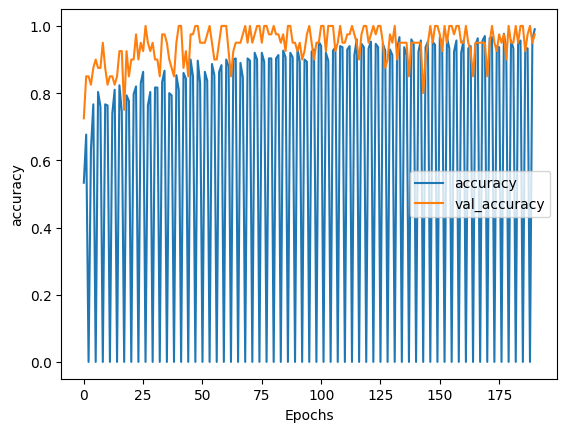

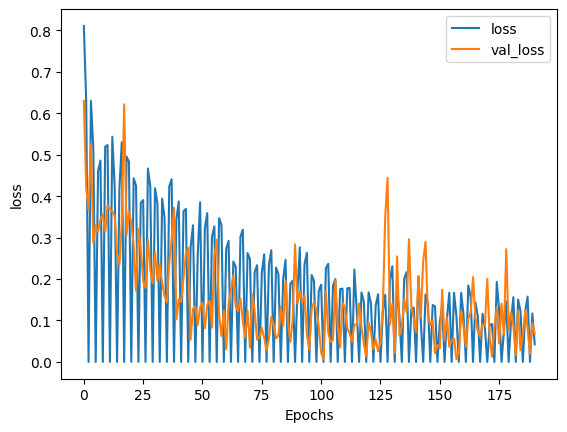

In [14]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Confusion Matrix
Accuracy for 25 Test Data =  32.0
Accuracy for 50 Test Data =  38.775510204081634
Accuracy for 75 Test Data =  40.0
Accuracy for 100 Test Data =  38.38383838383838


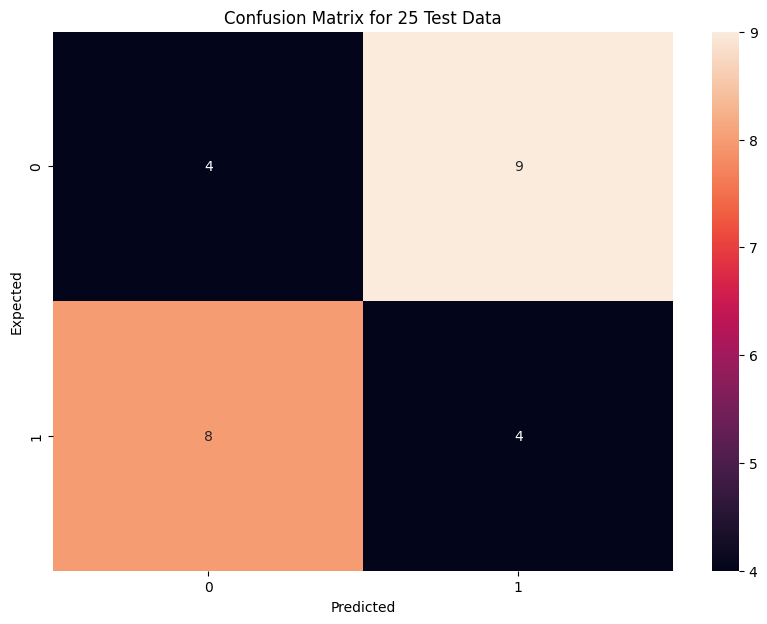

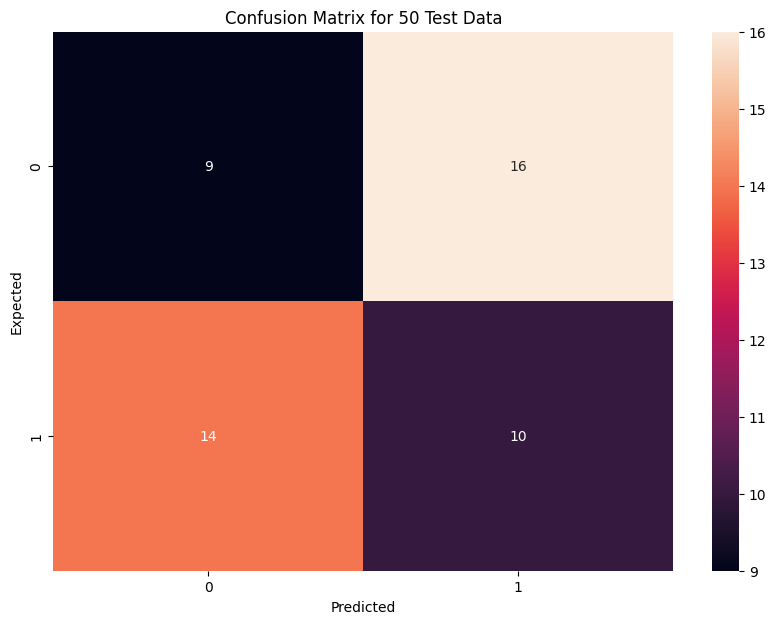

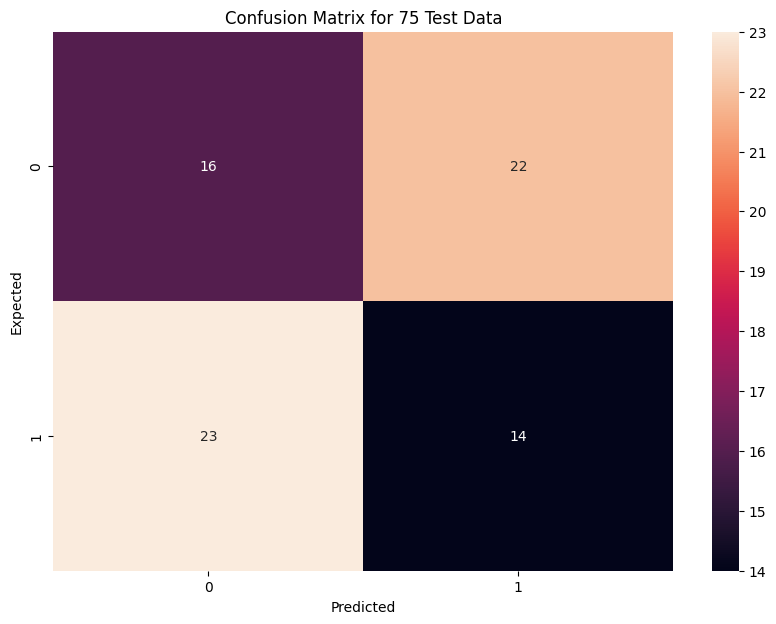

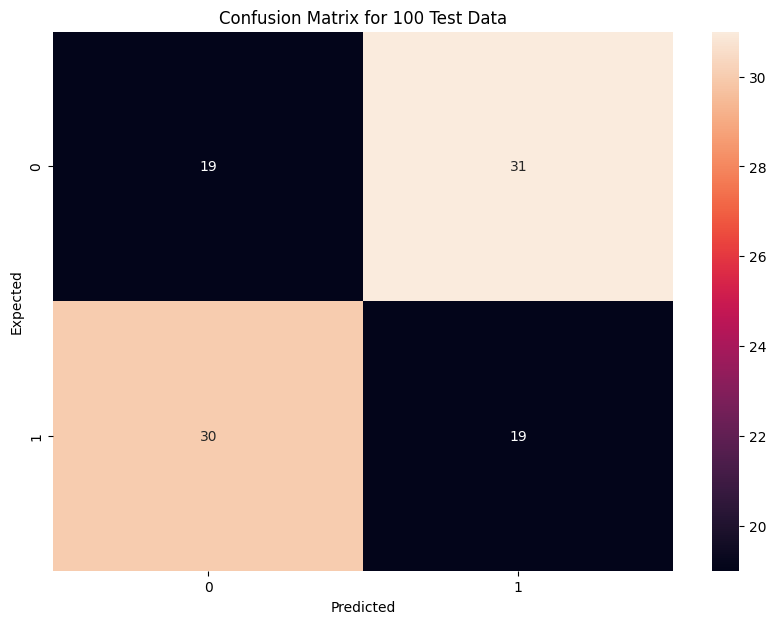

In [15]:
import seaborn
import numpy as np
y_pred = model.predict(validation_generator, 20)
print('Confusion Matrix')
y_predicted_labels = y_pred > 0.5

size = np.size(y_predicted_labels)
y_predicted_labels = y_predicted_labels.reshape(size, )

for i in range (1, 5):
  total = i * size // 4
  mid = 49
  start = mid-((total+1)//2)+1
  end = mid+((total+1)//2)
  cm = tf.math.confusion_matrix(labels=validation_generator.labels[start:end],predictions=y_predicted_labels[start:end])

  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for", str(total), "Test Data = ", conf_acc)

  # Plot the confusion matrix
  plt.figure(figsize = (10,7))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for " + str(total) + " Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')

## Saving the model locally

In [16]:
# Save and convert the model (Used for deploying in web application)
model.save('../models/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

Saved the model successfully
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
created virtual environment CPython3.11.9.final.0-64 in 166ms
  creator CPython3Posix(dest=/home/kali/Desktop/redact-sih/notebooks/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/kali/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==70.3.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator
2024-08-28 20:54:42.169751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 20:54:42.184504: E external/local_xla/xla/stream_executor/cuda/cuda_

## Sample Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
[1.]
../data/images/training/sensitive/aadharcard (2).jpg - Sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[1.]
../data/images/training/sensitive/aadharcard (3).jpg - Sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1.]
../data/images/training/nonsensitive/COCO_train2014_000000000030.jpg - Sensitive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[1.]
../data/images/training/nonsensitive/COCO_train2014_000000000009.jpg - Sensitive


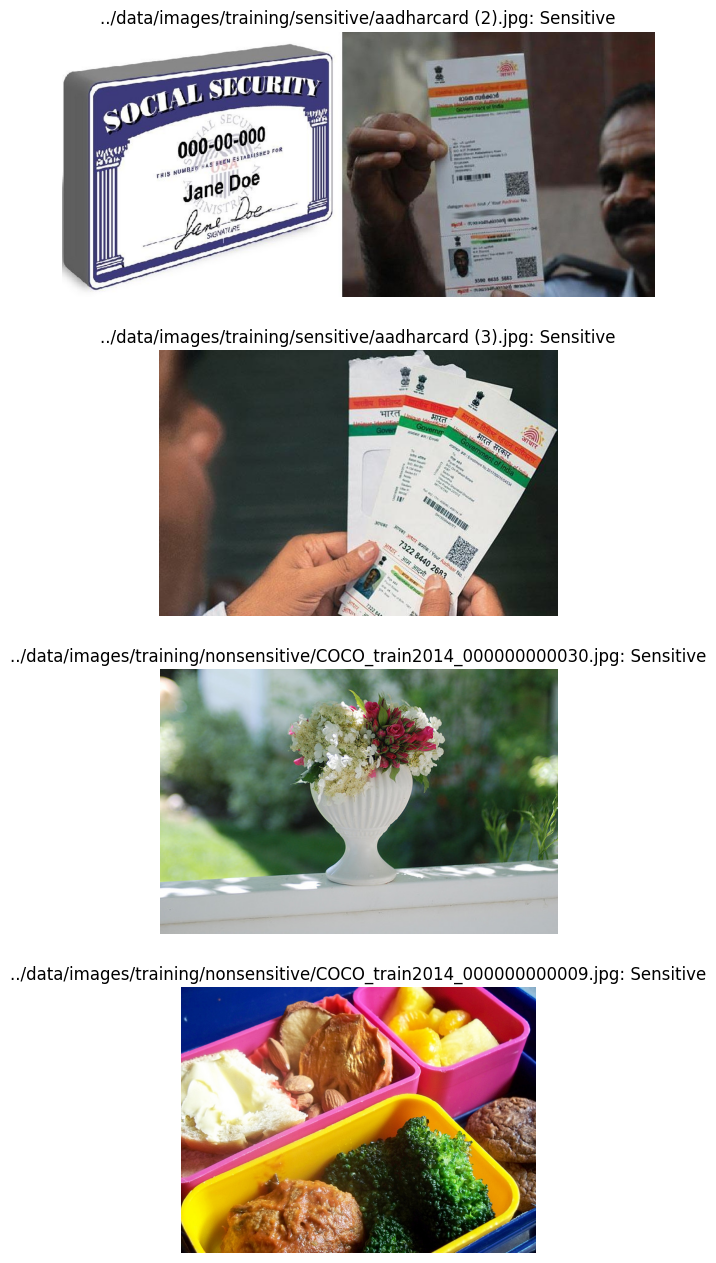

In [17]:
from keras.preprocessing import image

sample_data = ['../data/images/training/sensitive/aadharcard (2).jpg',
               '../data/images/training/sensitive/aadharcard (3).jpg',
               '../data/images/training/nonsensitive/COCO_train2014_000000000030.jpg',
               '../data/images/training/nonsensitive/COCO_train2014_000000000009.jpg']
result = dict()

for path in sample_data:
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0] > 0.5:
        print(path + " - Sensitive")
        result[path] = "Sensitive"
    else:
        print(path + " - Non-sensitive")
        result[path] = "Non-sensitive"

plt.figure(figsize=(20, 20))

for i, fn in enumerate(sample_data):
    image = plt.imread(fn)
    plt.subplot(5, 1, i+1)
    plt.axis("off")
    plt.imshow(image)
    ans = fn + ": " + result[fn]
    plt.title(ans)